# Neural Networks - Lab 3: Deep Learning
### `Team 42`
#### *Dimos Dimitris - 031 17 165*
#### *Kopsinis Konstantinos - 031 17 062*
#### *Dimopoulos Christos - 031 17 037*

We assume that the current directory is `/content/drive/MyDrive/nn_lab3`.

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/nn_lab3/

MAIN_PATH = '/content/drive/MyDrive/nn_lab3/'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1BoX_Szu1GupHYsuLN6DUnMOtmdxc7WnK/nn_lab3


In [2]:
# general imports
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import collections
import random
import numpy as np
import os
import time
import pandas as pd
from PIL import Image
from tqdm import tqdm
from tqdm import notebook
import json

# BLEU score
import nltk.translate.bleu_score as bleu_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

# extra import - not crucial
from pathlib import Path
from humanize import naturalsize

# visualization options
sns.set()
sns.set_palette("flare")
color = cm.plasma(np.linspace(.4, .8, 30))

## Dataset: Flickr30k (flickr30k-images-ecemo)

In [3]:
# data directories
image_folder = 'image_dir/'
image_folder_npy = 'image_dir_npy/'

In order to download the data to your local drive, make sure that there are at least 10GB of free space.

In [4]:
# download and extract the dataset zip
if not os.path.exists(MAIN_PATH + image_folder): # check if the data is already present
    image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=MAIN_PATH,
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
    os.remove(image_zip)

# download train captions
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=MAIN_PATH,
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)

# download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=MAIN_PATH,
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

In [8]:
# double-check data size
size = 0
for file_ in Path(MAIN_PATH + image_folder).rglob('*'):
    size += file_.stat().st_size
print("Size of data: " + naturalsize(size))

Size of data: 4.4 GB


Number of all images: 31784
This is a sample image


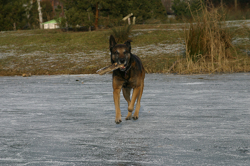

In [7]:
# how much image data?
print("Number of all images: " + str(len(os.listdir(MAIN_PATH + image_folder))))

# visualize a random sample image
sample_img = Image.open('image_dir/_21619500.jpg') # image No 7
sample_dims = sample_img.size
sample_img = sample_img.resize((sample_dims[0]//2, sample_dims[1]//2))
print("This is a sample image")
sample_img

In [9]:
# check the captions corresponding to the above sample
with open('train_captions.csv', 'r') as file:
    temp = file.readline()
    while(temp):
        if (temp.split('|')[0] == "_21619500.jpg"):
            print(temp)
        temp = file.readline()

_21619500.jpg| 0| A black and brown dog walks on the frozen surface of a pond , holding a stick .

_21619500.jpg| 1| A brown dog is carrying a stick in his mouth across an ice covered pond .

_21619500.jpg| 2| A brown dog walking on a frozen lake carrying a stick .

_21619500.jpg| 3| The big dog is carrying an object is its mouth .

_21619500.jpg| 4| A big dog carries a stick across a frozen pond .



In [10]:
# general form of the train_captions.csv
with open(train_captions_file, 'r') as f:
    train_captions = pd.read_csv(f, sep='|', header=None, quoting=3)

train_captions.columns = ["Image", "CapNum", "Caption"]
train_captions.head(3)

,Image,CapNum,Caption
0,_1000070808.jpg,0,A little girl holds orange lilies while other...
1,_1000070808.jpg,1,A little girl at a wedding holds a bouquet of...
2,_1000070808.jpg,2,Young girl in orange dress holding orange flo...


In [11]:
# how many of the data are to be test data
df = pd.read_csv("test_images.csv")
print("Number of test images: " + str(df.shape[0]+1))

Number of test images: 2000


## Group the captions with common image_ids (and optionally limit the training set)

In [12]:
image_path_to_caption = collections.defaultdict(list)
for index, val in train_captions.iterrows():
    caption = f"<start> {val['Caption']} <end>"
    image_path = MAIN_PATH + 'image_dir/' + val['Image']
    image_path_to_caption[image_path].append(caption)

We keep a dictionary `image_path_to_caption` that matches the captions to the corresponding image paths.

In [15]:
# visualize dict contents
for key, value in image_path_to_caption.items():
    print(key, ': ', value)
    break

/content/drive/MyDrive/nn_lab3/image_dir/_1000070808.jpg :  ['<start>  A little girl holds orange lilies while others celebrate an occasion in a garden setting . <end>', '<start>  A little girl at a wedding holds a bouquet of orange flowers . <end>', '<start>  Young girl in orange dress holding orange flowers . <end>', '<start>  a girl at a wedding holding some orange flowers <end>', '<start>  A girl holds a bouquet of flowers <end>']


(Limitting the train set is optional. We will do it in the beginning to reduce the time our experiments need to run)

In [16]:
limit_dataset = True
keepOnly = 6000

We shuffle the ***train images*** and randomly keep the ***first 6000 images***. Each image corresponds to approx. 5 captions. This leads to a ***train dataset of 30000 examples***.

In [17]:
image_paths = list(image_path_to_caption.keys())

if limit_dataset:
    random.seed(42)
    random.shuffle(image_paths)
    train_image_paths = image_paths[:keepOnly]
else:
    train_image_paths = image_paths

print("Remaining images: ", len(train_image_paths))

Remaining images:  6000


Previously, we saw that the number of images in `image_dir` was 31784. (Given that we do not limit the data) we see that now we have 29782 images. This implies that we have more images than the ones mentioned in `train_captions.csv`.

At next, we create 2 lists: `img_name_vector[i]` contains the path to the image corresponding to caption `train_captions[i]`.

In [18]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

print("Number of remaining captions: ", len(train_captions))

Number of remaining captions:  30000


<start>  A woman leading a gray and black spotted dog in a red bandanna through a competition . <end>
<start>  A woman runs along side her dog as he jumps a hurdle . <end>
<start>  A dog with a bandanna jumps through hoop . <end>
<start>  A girl leads her dog over a hurdle . <end>
<start>  A dog and his trainer at a challenge <end>


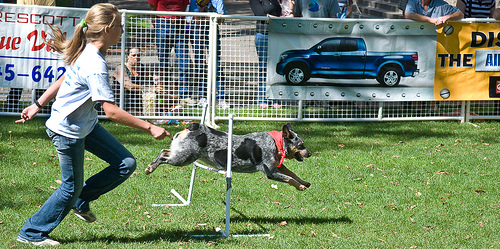

In [19]:
# print a sample image and all its captions
for i in range(5):
    print(train_captions[i])
Image.open(img_name_vector[0])

## Pretrained Feature Extractor (CNN - Xception)

We will use the Xception Network to encode our images. This network is already pretrained on ImageNet.

Out target is to use the convolutional layers of Xception to extract useful features from our images (aka encode them). This job is very time-consuming, therefore we will extract the features once and save them in a local directory in drive (`image_dir_npy`).

The files containing the features will be `.npy` files. This kind of (binary) file contains numpy arrays in a space-efficient way.

***1) Initialize Xception Model***

In [20]:
image_model = tf.keras.applications.Xception(include_top=False,
                                             weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

83697664/83683744 [==============================] - 1s 0us/step


***2) Preprocess the images, before passing them to Xception***

In [21]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

***3) Extract Features from Xception and cache them***

In [22]:
# get unique images
encode_train = sorted(set(img_name_vector))

# (batch_size is CHANGEABLE)

# tensor for each path
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# map each path to corresponding load_image(path)
image_dataset = image_dataset.map(load_image,
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(16)


# make sure that this process is executed ONLY ONCE
if not os.path.exists(MAIN_PATH + image_folder_npy):
    os.mkdir(MAIN_PATH + image_folder_npy)

    # EXTRACT FEATURES and CACHE THEM
    for img, path in tqdm(image_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features,
                                    (batch_features.shape[0], -1, batch_features.shape[3]))

        for bf, p in zip(batch_features, path):
                path_of_feature = MAIN_PATH + image_folder_npy + p.numpy().decode("utf-8").split('/')[-1]
                np.save(path_of_feature, bf.numpy())

In [23]:
# check npy file size
size = 0
for file_ in Path('/content/drive/MyDrive/nn_lab3/image_dir_npy').rglob('*'):
    size += file_.stat().st_size
print("Size of npy data: " + naturalsize(size))

Size of npy data: 24.4 GB


We will no longer need the Feature Extractor.

## Preprocess and Tokenize the Captions

***1) Truncate too long and the too short captions***

First, we plot a histogram to inspect the lengths that exists in our captions set.

In [24]:
train_captions_iter = train_captions.copy()
img_name_vector_iter = img_name_vector.copy()

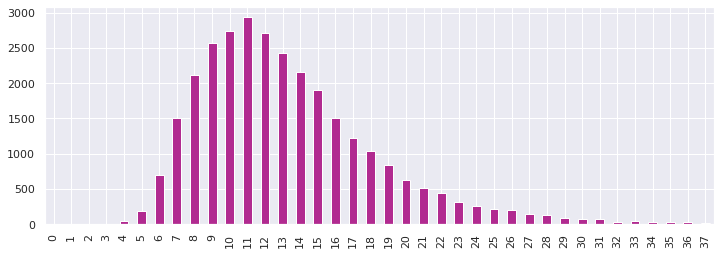

In [25]:
histogram = np.zeros(80, 'int')
for i in range(len(train_captions_iter)):
    caption_length = len(train_captions_iter[i].split(" "))-3 # remove <start>, <end>, space
    histogram[caption_length] += 1

df = pd.DataFrame(histogram[:38]) # show the 38 most frequent ones
df.plot(kind='bar', stacked=False, color=color, legend=False, figsize=(12, 4))
plt.show()

We now want to keep the 25th most frequent. We start by keeping the lengths from 5 to 30 words.

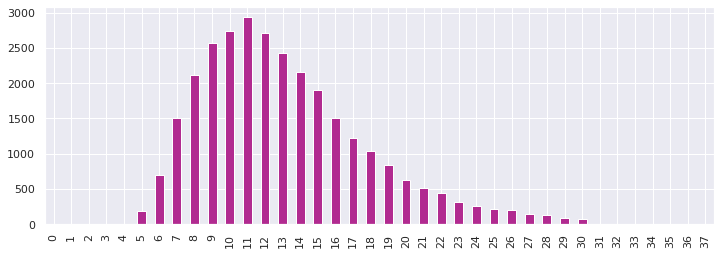

Before:  30000 30000
After:   29571 29571


In [28]:
# truncate the data
train_captions = []
img_name_vector = []
_min_ = 5 + 3 # (to also count the tags and space)
_max_ = 30 + 3 # (to also count the tags and space)

for i in range(len(train_captions_iter)):
    caption_length = len(train_captions_iter[i].split(" "))
    
    if (caption_length >= _min_ and caption_length <= _max_):
        train_captions.append(train_captions_iter[i])
        img_name_vector.append(img_name_vector_iter[i])

# replot the histogram
histogram = np.zeros(80, 'int')
for i in range(len(train_captions)):
    caption_length = len(train_captions[i].split(" ")) - 3 # remove <start>, <end>, space
    histogram[caption_length] += 1

df = pd.DataFrame(histogram[:38]) # show the 38 most frequent ones
df.plot(kind='bar', stacked=False, color=color, legend=False, figsize=(12, 4))
plt.show()

print("Before: ", len(train_captions_iter), len(img_name_vector_iter))
print("After:  ", len(train_captions), len(img_name_vector))

***2) Tokenize Captions***

In [29]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

MAX_LENGTH = _max_ # max caption length
VOCABULARY_SIZE = 5000  # use the top VOCABULARY_SIZE words for a vocabulary

tokenizer = tf.keras.layers.TextVectorization(max_tokens=VOCABULARY_SIZE,
                                              standardize=standardize,
                                              output_sequence_length=MAX_LENGTH)

# adapt tokenizer to caption data (learn vocabulary)
tokenizer.adapt(caption_dataset)

Now tokenize the captions

In [30]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [31]:
# create mappings for words to indices and indices to words
word_to_index = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="",
                                             vocabulary=tokenizer.get_vocabulary(),
                                             invert=True)

## Prepare the dataset for our Models

***1) Split into Training and Validation Sets***

In [32]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# we use this random seed to ensure that our models
# keep the same validation set after we reload them
random.seed(42)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

# slice_index determines the percentage of validation data
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

***Summary*** (given that we have limited the image dataset before - `limit_datset=True`):

- For a 80-20 split:
    - `img_name_train_keys`: 4800 img_ids (80% of 6000)
    - `img_name_val_keys`: 1200 img_ids (20% of 6000)

- Train Set:
    - `img_name_train[i]`: img_id corresponding to i-th (tokenized) caption
    - `cap_train[i]`: i-th tokenized caption (each caption has `max_length` elements - for our experiments we use `max_length=30`)
    - the 2 lists have the same length

- The same applies to the Validation Set, respectively.

In [33]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23657, 23657, 5914, 5914)

***2) Turn into tf.data dataset for training***

In [34]:
# hyperparameters

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256 # features --> FC_encoder --> output_dim = embedding_dim
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

We want to define two variables: `features_shape` and `attention_features_shape`. These variables represent the output vector shape of Xception. We double-check those dimensions, by loading an Xception output.

In [35]:
dummy = np.load(MAIN_PATH + image_folder_npy + img_name_train[0].split('/')[-1] +'.npy')
print(dummy.shape)

(100, 2048)


In [36]:
# shape of the vector extracted from Xception is (100, 2048)
# these two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [37]:
# load the numpy files
def map_func(img_name, cap):
    # We expect img_name to be like img_name_train[i]
    # BYTE ENCODED DUE TO tf.map. This is why we need .decode('utf-8')
    img_tensor = np.load(MAIN_PATH + image_folder_npy + img_name.decode('utf-8').split('/')[-1] +'.npy')
    return img_tensor, cap

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# map img_name_train to its feature representations (in parallel)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func,
                                                             [item1, item2],
                                                             [tf.float32, tf.int64]
                                                             ),
                      num_parallel_calls=tf.data.AUTOTUNE)

# shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
print(next(iter(dataset))[0].shape, next(iter(dataset))[1].shape)

(64, 100, 2048) (64, 33)


In [39]:
print("For len(img_name_train) = {}, we get #batches = {}".format(len(img_name_train),
                                                                  tf.data.experimental.cardinality(dataset).numpy()
                                                                  ))

For len(img_name_train) = 23657, we get #batches = 370


The dataset is ready. It consists of pairs of the form:

$$(\underbrace{features}_{(batch\_size \;\times\; 100 \;\times\; 2048)}, \underbrace{caption_{token}}_{(batch\_size \;\times\; max\_length)})$$

## Model: CNN Encoder $\rightarrow$ RNN (GRU) Decoder

*Input to CNN Encoder: Output of Xception* `(100 x 2048)`

*CNN Encoder: A single fully connected layer*

*Output of CNN Encoder: Input to Attention layer of Decoder* `(100 x embedding_dim)`

***1) Define Model Architectures***

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 100, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 100, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 100, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 100, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# encoder model: passes the Xception output features through a fc layer
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        # output shape: (batch_size, 100, embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
# decoder model (GRU)
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

***2) Initialize Encoder and Decoder Models***

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
optimizer = tf.keras.optimizers.Adam()

***3) Define Loss Function***

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = MAIN_PATH + "checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target, encoder, decoder, optimizer):
    loss = 0

    # initializing the hidden state for each batch, since the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

***Main Training Procedure***

In [ ]:
goTrain = False

In [ ]:
EPOCHS = 20

if goTrain:
    for epoch in range(start_epoch, EPOCHS):
        print("\n\nEPOCH: {}".format(epoch))
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            # print(batch, end=' ')
            # print(img_tensor.shape, target.shape)
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)

        if epoch % 5 == 0:
            ckpt_manager.save()

        print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

`Epoch 20 Loss 0.560637`

***Plot the Train Loss***

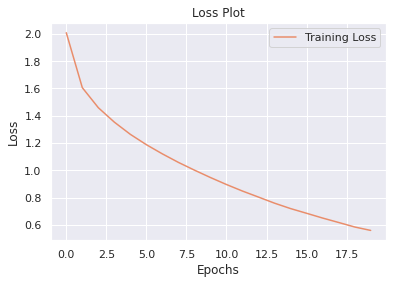

In [ ]:
plt.plot(loss_plot, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

***Evaluate the Model***

In [ ]:
# image: image_dir element
def evaluate(image):
    attention_plot = np.zeros((MAX_LENGTH, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    #img_tensor_val = np.load(MAIN_PATH + image_folder_npy + image.split('/')[-1] +'.npy')

    #THE TUTORIAL'S CODE EXTRACTED FEATURES EVERY TIME evaluate WAS CALLED
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(MAX_LENGTH):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# function to test model's performance on either train/val sample
def test_on_train_or_val(train=False):
    set_ = img_name_train if train else img_name_val
    cap_ = cap_train if train else cap_val
    
    rid = np.random.randint(0, len(set_))
    #rid = 55
    print("Image No: ", rid)
    image = set_[rid]
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                            for i in cap_[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(image, result, attention_plot)

Image No:  4055
Real Caption: <start> a professional motor racer in motion . <end>
Prediction Caption: a this picture on a red gloves on the corner . <end>


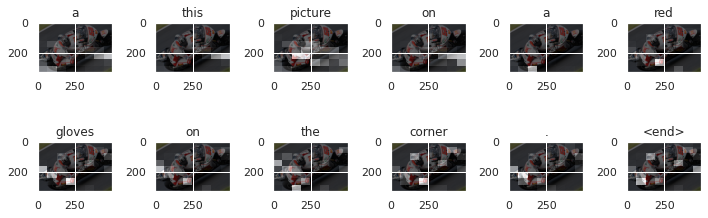

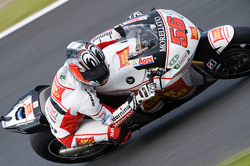

In [ ]:
test_on_train_or_val(False)
print()
img_4055 = Image.open(img_name_val[4055])
sample_dims = img_4055.size
img_4055 = img_4055.resize((sample_dims[0]//2, sample_dims[1]//2))
img_4055



| Some Prediction Captions for Validation Image No 4055|
| :-  -:
| a tattooed motorcyclist still has and other with helmets going around his right . \<end> | 
| a man on their neck [UNK] outside . \<end> | 
| a man on the other helmet . \<end> | 
| there are leaning down a racetrack . \<end> |
| a man wearing blue helmet going around a corner of a racetrack . \<end> |



Image No:  2000
Real Caption: <start> a man wearing jeans is working to make a sculpture in the sand . <end>
Prediction Caption: a young child standing on a rock with a hammer . <end>


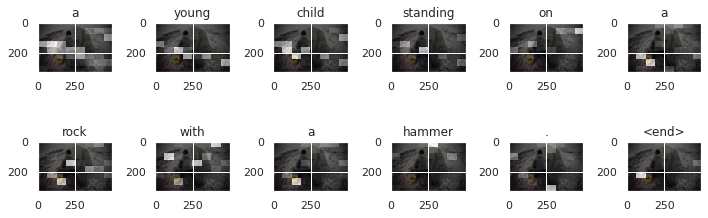

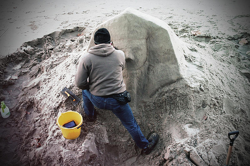

In [ ]:
test_on_train_or_val(False)
print()
img_2000 = Image.open(img_name_val[2000])
sample_dims = img_2000.size
img_2000 = img_2000.resize((sample_dims[0]//2, sample_dims[1]//2))
img_2000



| Some Prediction Captions for Validation Image No 2000|
| :-  -:
| a young child in a red sash is holding a shaved head wrap himself . \<end> |
| child in sunglasses , is making a pile . \<end> |
| a child wearing glasses is bending and red pants , with glasses and a blue shirt is holding him . \<end> |
| a little girl , standing in the sand . \<end> 
| boy is standing on a rock . \<end> |



At this point we have finished with training our first simple model. Taking a look on some predictions in the validation set, we see that our model's predictions are far from satisfying. However, what is interesting is that there seems to exist some semantic importance in the model's captions, despite them not being very similar to the real ones. For example, on Image No: 4055, the model seems to be able to deduce that:

1. the depicted person is human,
2. that there is red color in the pic,
3. that there is a racetrack,
4. there is movement to the right and
5. that the the motorcyclist is leaning.

This implies that a better fine-tuning of the model's parameters and more data may, in fact, improve its performance even further. Let's have a look at our model's performance on a sample of the training set:

Image No:  55
Real Caption: <start> a man plays an instrument on the sidewalk for tips . <end>
Prediction Caption: two mannequins are enjoying a world exhibition . <end>


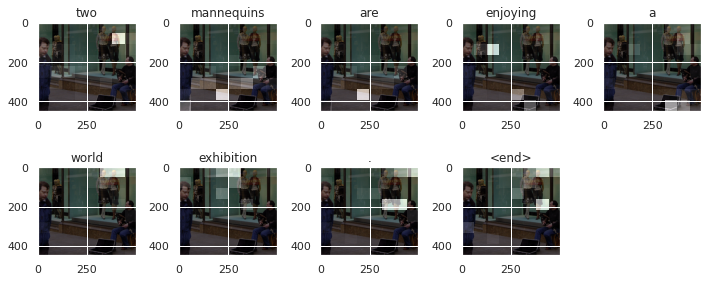

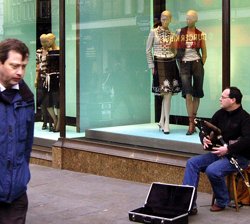

In [ ]:
test_on_train_or_val(True)
print()
img_55 = Image.open(img_name_train[55])
sample_dims = img_55.size
img_55 = img_55.resize((sample_dims[0]//2, sample_dims[1]//2))
img_55

| Real Captions for Train Image No 55|
| :-  -:
| \<start> two mannequins are standing in the window behind a man who is taking a break from playing an instrument . \<end> |
| \<start> a man is sitting on a chair on the sidewalk with bagpipes in front of a store . \<end> |
| \<start> a bagpipe street performer in front of a store window . \<end> |
| \<start> a man plays an instrument on the sidewalk for tips . \<end> |
| \<start> [UNK] on the street of a city . \<end> |

\\

| Some Prediction Captions for Train Image No 55|
| :-  -:
| a trio of mannequins are standing on a jewelry store <end> |
| a man taking a music on a street corner in a bus <end>|
| the mannequins are standing , hanging out on the sidewalk in lawn . <end> |
| a man wearing a green shirt is sitting outside . <end> |
| two mannequins on a subway shop . <end> |
| four elderly jewish men and an old street in the two men , one is playing a black shirt , sitting on a sidewalk beside them . <end> |

From the above results we can deduce similar conclusions about the images of the train set, but (as expected) the predicted captions are both semantically important and closer to at least one real caption.

***Restoring a saved model***

In [ ]:
def initialize_model(embedding_dim, units, learning_rate, tokenizer):
    encoder = CNN_Encoder(embedding_dim)
    decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    return encoder, decoder, optimizer

In [ ]:
def restore_saved_model(checkpoint_path, encoder, decoder, optimizer):
    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    ckpt.restore(ckpt_manager.latest_checkpoint)

    if ckpt_manager.latest_checkpoint:
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return encoder, decoder, optimizer

This is how we would reload a model.
```python
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=embedding_dim,
                                               units=units,
                                               learning_rate=learning_rate, 
                                               tokenizer=tokenizer)

# load a checkpoint on it
encoder, decoder, optimizer = restore_saved_model(MAIN_PATH + "checkpoints/train",
                                                  encoder=encoder,
                                                  decoder=decoder,
                                                  optimizer=optimizer)
```                                                  

***
***This is the end of training a basic captioning system***
***

From this point onward, we work on the following topics (in the order mentioned):

1. ✅ Define a function for preparing specific dataset splits:
    - Splits train dataset in desired train/validation percentages
2. ✅ Define a function to evaluate a model on validation set
    - Uses the defined loss function (modified Sparse Categorical Cross Entropy)
    - Returns (on command) the model's predictions (to be used to compute BLEU metric)
3. ✅ Define the BLEU evaluation metric
4. ✅ Redefine our training functions (using ***early stopping*** based on the validation set).

✅ Retrain a new model (in a more automated way now) and evaluate it using BLEU metric

5. ✅ Implement a custom Sentence Generator using Beam Search 
6. ✅ Attempt to improve our model. Axes of interest:
    - Use Gensim's glove-wiki pretrained embeddings
    - Add dropout layers (Regularization)
    - Experiment on Decoder's cell cardinality
    - Experiment on `EPOCH` and `BATCH_SIZE` hyperparameters


## ***1) Dataset Preparation Automated***

In [ ]:
def split_train_test(train_percent):

    random.seed(42) # we need the same splitting for testing purposes

    # shuffle
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)
    # split
    slice_index = int(len(img_keys)*train_percent)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    img_name_train = []
    cap_train = []
    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    img_name_val = []
    cap_val = []
    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    # convert train_dataset to tf.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
    train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func,
                                                                             [item1, item2],
                                                                             [tf.float32, tf.int64]),
                                num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # convert val_dataset to tf.Dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
    val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func,
                                                                         [item1, item2],
                                                                         [tf.float32, tf.int64]),
                                num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset

## ***2) Model Evaluation on Validation Set***

We designed this function to return the loss of a given model on validation set and also return the model's predictions when we ask it to (`return_preds=True`).

In [ ]:
def model_evaluation(encoder, decoder, val_dataset, return_preds=False):
    total_loss = 0
    no_targets_yet = True

    for batch, (img_tensor, target) in notebook.tqdm(enumerate(val_dataset)):
        batch_loss = 0

        # initializing the hidden state for each batch
        hidden = decoder.reset_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

        # pass through encoder
        features = encoder(img_tensor)

        no_predictions_yet = True
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            batch_loss += loss_function(target[:, i], predictions)
            predicted_id = tf.random.categorical(predictions, 1)#.numpy()
            dec_input = predicted_id

            if return_preds:
                predicted_word = index_to_word(predicted_id).numpy().astype(str)
                if no_predictions_yet:
                    predicted_sentences = predicted_word
                    no_predictions_yet = False
                else: # collect predictions
                    predicted_sentences = np.concatenate((predicted_sentences, predicted_word), axis=1)

        # also collect target sentences
        if return_preds:
            if no_targets_yet:
                all_target_sentences = target.numpy()
                all_predicted_sentences = predicted_sentences
                no_targets_yet = False
            else:
                all_target_sentences = np.vstack( (all_target_sentences, target.numpy()) )
                all_predicted_sentences = np.vstack( (all_predicted_sentences, predicted_sentences) )
        
        t_loss = (batch_loss / int(target.shape[1]))
        total_loss += t_loss

    if return_preds:
        return total_loss/batch, (all_target_sentences, all_predicted_sentences)
    else:
        return total_loss/batch
    # 'batch' equals # batches, so 'total_loss/batch' equals the overall validation loss

## ***3) BLEU Evaluation Metric***

***
***Auxiliary functions needed before applying BLEU***

In [ ]:
# matches all tokenized captions to their original untokenized form
def get_token_to_caption_dict():
    token_to_caption = dict()
    for caption in notebook.tqdm(train_captions):
        token = str(list(tokenizer(caption).numpy()))
        token_to_caption[token] = caption
    return token_to_caption

In [ ]:
# returns: dict[img] --> list_of_grouped_references
def get_reference_dict():
    dict_of_references = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, train_captions):
        dict_of_references[img].append(cap)
    return dict_of_references

In [ ]:
# processes a real caption (removes tags)
def process_target(trg):
    #l = ' '.join(trg)
    l = trg.lower().split('<end>')[:-1]
    l = ' '.join(l)
    l = l.split(' ')[2:-2]
    return l

In [ ]:
# process predicted caption (remove tags, truncate after the first <end>)
def process_pred(prd):
    k = ' '.join(prd)
    if '<end>' in k:
        k = k.split('<end>')[0]
        k = k.split(' ')[:-1]
        return k
    return k.split(' ')

***
***Main BLEU Computation***

In [ ]:
weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

In [ ]:
def evaluate_model_BLEU(encoder, decoder, validation_set):
    print(' --- Evaluating Model using BLEU Metric --- ')
    dict_of_references = get_reference_dict() # groups the references to the same img
    _, (all_targets, all_preds) = model_evaluation(encoder, decoder, validation_set, return_preds=True)

    list_of_references = []
    hypotheses = []

    for i in notebook.tqdm(range(all_preds.shape[0])):
        cur_hypo = all_preds[i]
        cur_refe = all_targets[i]

        # token_to_caption COMPUTED OUTSIDE ONCE (takes time)
        cur_refe_key = str(list(cur_refe))
        original_refe = token_to_caption[cur_refe_key]

        # in form convenient for comparison
        comparable_refe = ''.join(original_refe.split(' ')).lower()

        found = False
        for key in dict_of_references:
            group = dict_of_references[key]
            comparable_group = [''.join(j.split(' ')).lower() for j in group]

            if comparable_refe in comparable_group: # find the corresponding group of refs

                # process the captions
                processed_group_of_refs = [process_target(i) for i in group]
                processed_hypothesis = process_pred(cur_hypo)

                list_of_references.append(processed_group_of_refs)
                hypotheses.append(processed_hypothesis)
                found = True
                break

        if not found:
            print('Error')
            break
    
    bleu_metric = corpus_bleu(list_of_references, hypotheses, weights, smoothing_function)
    return bleu_metric

Note: after finishing implementing this function we realized that it was not necessary to produce a prediction for every caption, but one for every image. This does not necessarily invalidate this evaluation. It is simply more time consuming and constitutes a kind of variation of the standard BLEU. Later on, we will produce a caption for each image and, therefore, abandon this implementation, despite it employing parallel computation.

## ***4) Redefine the Training Functions***

In [ ]:
# main training function
def train_model_re(encoder, decoder, optimizer, train_set, val_set, epochs, ckpt_manager, early_stopping=False):
    train_losses = []
    val_losses = []
    early_counter = 0
    val_loss_opt = np.inf

    for epoch in range(epochs):
        print(f' --- Epoch {epoch+1} --- ')
        start = time.time()
        total_train_loss = 0

        for batch, (img_tensor, target) in notebook.tqdm(enumerate(train_set)):
            
            batch_loss, t_loss = train_step(img_tensor, target, encoder, decoder, optimizer)
            total_train_loss += t_loss

            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Batch {batch}:\t Average Batch Loss {average_batch_loss:.4f}')
        
        epoch_train_loss = total_train_loss/batch # total/num_of_batches
        #print('...Evaluating Model on Validation Set')
        #epoch_val_loss = model_evaluation(encoder, decoder, val_set, return_preds=False)

        train_losses.append(epoch_train_loss)
        #val_losses.append(epoch_val_loss)

        print(f'Epoch Train Loss: {epoch_train_loss:.6f}')# \t Epoch Validation Loss: {epoch_val_loss:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

        if early_stopping:
            if val_loss_opt > epoch_val_loss:
                val_loss_opt = epoch_val_loss
                ckpt_manager.save()
            if early_counter == 5:
                break
            early_counter += 1
        elif epoch % 5 == 0:
                ckpt_manager.save()

    return train_losses, val_losses 

***
***Retrain a model***

In [ ]:
## hyperparameters

# dataset
BATCH_SIZE = 64
BUFFER_SIZE = 1000
TRAIN_PERCENT = 0.8

# models
embedding_dim = 256 # features --> FC_encoder --> output_dim = embedding_dim
units = 512
lr = 1e-3

# training
EPOCHS = 20

In [ ]:
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=embedding_dim,
                                               units=units,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)

In [ ]:
# create a checkpoint
checkpoint_path_m2 = MAIN_PATH + "checkpoints/model2"
ckpt_m2 = tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer=optimizer)
ckpt_manager_m2 = tf.train.CheckpointManager(ckpt_m2, checkpoint_path_m2, max_to_keep=2)

In [ ]:
# prepare the datasets
train_set_m2, val_set_m2 = split_train_test(train_percent=TRAIN_PERCENT)

In [ ]:
train_losses_m2, val_losses_m2 = train_model_re(encoder=encoder,
                                                decoder=decoder,
                                                optimizer=optimizer,
                                                train_set=train_set_m2,
                                                val_set=val_set_m2,
                                                epochs=EPOCHS,
                                                ckpt_manager=ckpt_manager_m2,
                                                early_stopping=False)

 --- Epoch 1 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.7292
Batch 101:	 Average Batch Loss 1.7485
Batch 201:	 Average Batch Loss 1.6844
Batch 301:	 Average Batch Loss 1.5093
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.604563 	 Epoch Validation Loss: 3.536378
Time taken for 1 epoch 195.84 sec

 --- Epoch 2 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.5401
Batch 101:	 Average Batch Loss 1.4431
Batch 201:	 Average Batch Loss 1.6451
Batch 301:	 Average Batch Loss 1.4179
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.459545 	 Epoch Validation Loss: 3.621112
Time taken for 1 epoch 189.63 sec

 --- Epoch 3 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.3637
Batch 101:	 Average Batch Loss 1.3630
Batch 201:	 Average Batch Loss 1.4607
Batch 301:	 Average Batch Loss 1.4782
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.350433 	 Epoch Validation Loss: 3.699296
Time taken for 1 epoch 194.37 sec

 --- Epoch 4 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.3984
Batch 101:	 Average Batch Loss 1.2071
Batch 201:	 Average Batch Loss 1.2598
Batch 301:	 Average Batch Loss 1.2157
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.261521 	 Epoch Validation Loss: 3.757535
Time taken for 1 epoch 189.33 sec

 --- Epoch 5 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.2867
Batch 101:	 Average Batch Loss 1.2640
Batch 201:	 Average Batch Loss 1.1181
Batch 301:	 Average Batch Loss 1.0499
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.183336 	 Epoch Validation Loss: 3.847875
Time taken for 1 epoch 189.39 sec

 --- Epoch 6 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.2044
Batch 101:	 Average Batch Loss 1.1826
Batch 201:	 Average Batch Loss 1.1378
Batch 301:	 Average Batch Loss 1.0760
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.114903 	 Epoch Validation Loss: 3.923525
Time taken for 1 epoch 191.07 sec

 --- Epoch 7 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.9994
Batch 101:	 Average Batch Loss 1.1162
Batch 201:	 Average Batch Loss 1.0937
Batch 301:	 Average Batch Loss 1.0605
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 1.052445 	 Epoch Validation Loss: 4.041417
Time taken for 1 epoch 190.11 sec

 --- Epoch 8 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 1.1030
Batch 101:	 Average Batch Loss 0.9352
Batch 201:	 Average Batch Loss 0.9287
Batch 301:	 Average Batch Loss 0.8674
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.994093 	 Epoch Validation Loss: 4.087574
Time taken for 1 epoch 190.27 sec

 --- Epoch 9 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.9097
Batch 101:	 Average Batch Loss 0.9762
Batch 201:	 Average Batch Loss 0.8745
Batch 301:	 Average Batch Loss 0.9774
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.939222 	 Epoch Validation Loss: 4.199321
Time taken for 1 epoch 189.80 sec

 --- Epoch 10 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.9413
Batch 101:	 Average Batch Loss 0.8516
Batch 201:	 Average Batch Loss 0.9491
Batch 301:	 Average Batch Loss 0.8677
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.886432 	 Epoch Validation Loss: 4.359328
Time taken for 1 epoch 191.06 sec

 --- Epoch 11 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.8782
Batch 101:	 Average Batch Loss 0.7764
Batch 201:	 Average Batch Loss 0.7898
Batch 301:	 Average Batch Loss 0.8047
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.839107 	 Epoch Validation Loss: 4.558931
Time taken for 1 epoch 190.49 sec

 --- Epoch 12 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.7809
Batch 101:	 Average Batch Loss 0.7613
Batch 201:	 Average Batch Loss 0.7486
Batch 301:	 Average Batch Loss 0.7478
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.792831 	 Epoch Validation Loss: 4.531036
Time taken for 1 epoch 191.46 sec

 --- Epoch 13 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.7026
Batch 101:	 Average Batch Loss 0.7624
Batch 201:	 Average Batch Loss 0.7004
Batch 301:	 Average Batch Loss 0.7455
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.749744 	 Epoch Validation Loss: 4.809389
Time taken for 1 epoch 190.51 sec

 --- Epoch 14 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.7344
Batch 101:	 Average Batch Loss 0.6817
Batch 201:	 Average Batch Loss 0.6926
Batch 301:	 Average Batch Loss 0.7096
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.708839 	 Epoch Validation Loss: 4.874190
Time taken for 1 epoch 190.68 sec

 --- Epoch 15 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.6639
Batch 101:	 Average Batch Loss 0.6876
Batch 201:	 Average Batch Loss 0.7433
Batch 301:	 Average Batch Loss 0.6758
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.672853 	 Epoch Validation Loss: 5.022989
Time taken for 1 epoch 191.07 sec

 --- Epoch 16 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.6983
Batch 101:	 Average Batch Loss 0.6012
Batch 201:	 Average Batch Loss 0.6208
Batch 301:	 Average Batch Loss 0.5932
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.637338 	 Epoch Validation Loss: 5.081661
Time taken for 1 epoch 191.47 sec

 --- Epoch 17 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.6377
Batch 101:	 Average Batch Loss 0.5866
Batch 201:	 Average Batch Loss 0.5885
Batch 301:	 Average Batch Loss 0.5514
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.606081 	 Epoch Validation Loss: 5.273185
Time taken for 1 epoch 191.81 sec

 --- Epoch 18 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.6044
Batch 101:	 Average Batch Loss 0.6108
Batch 201:	 Average Batch Loss 0.5226
Batch 301:	 Average Batch Loss 0.6209
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.576647 	 Epoch Validation Loss: 5.377322
Time taken for 1 epoch 190.28 sec

 --- Epoch 19 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.6092
Batch 101:	 Average Batch Loss 0.5135
Batch 201:	 Average Batch Loss 0.5102
Batch 301:	 Average Batch Loss 0.5099
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.548072 	 Epoch Validation Loss: 5.571399
Time taken for 1 epoch 190.31 sec

 --- Epoch 20 --- 


0it [00:00, ?it/s]

Batch 1:	 Average Batch Loss 0.5591
Batch 101:	 Average Batch Loss 0.5249
Batch 201:	 Average Batch Loss 0.5693
Batch 301:	 Average Batch Loss 0.4894
...Evaluating Model on Validation Set


0it [00:00, ?it/s]

Epoch Train Loss: 0.521434 	 Epoch Validation Loss: 5.706200
Time taken for 1 epoch 190.79 sec



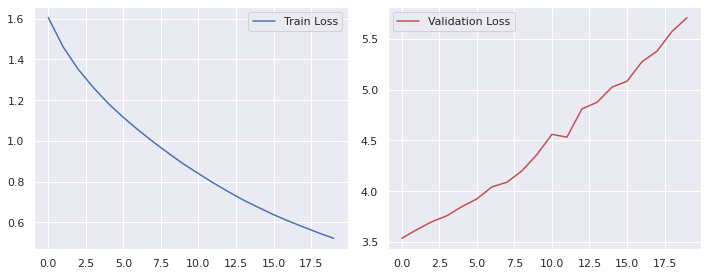

In [ ]:
sns.set()
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.autolayout"] = True

fig, axs = plt.subplots(1, 2)
axs[0].plot(train_losses_m2, label='Train Loss')
axs[1].plot(val_losses_m2, color='r', label='Validation Loss')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper left')
plt.show()

We just trained a second model with exactly the same characteristics as our first one, in order to doublecheck our redefined functions and also "heat up cache memory" (we have observed that the first epoch may need even 2 hours to finish, but the next ones are very fast. This implies that once the data is loaded in cache, it can be quickly processed afterwards).

From the above experiment (in which we have incoporporated model evaluation on validation set) we can observe the following:

- The train loss takes values very similar to those of the first model, which implies that this combination of model and dataset characteristics results in this performance without it being random.

- We observe that the validation loss, not only is not decreasing along with the train loss, but rather increases epoch by epoch. This fact implies that out model, despite being (somewhat) good at learning, cannot generalize very easily. This problem may be due to the following causes:
    - the words contained in the validation set, may not be very frequent in the training set, hence the model fails to accurately predict them
    - the `VOCABULARY_SIZE` may not be large enough to provide the model with the capacity of integrating less frequent words. This parameter is either way set to a small value (5000 is rather small, considering evaluation on real datasets and possibly generalization) for experimenting reasons.
    - the data is not sufficient
    - the problem of image captioning is generally very difficult to approach and generalize. Since the language (English) is very rich, it is only natural for the model to "overfit" on the train set, since the latter is not quite representative of the language as a whole.
    
To address this issue, we should experiment with the `VOCABULARY_SIZE` parameter and the amount of data employed to the training procedure. However, there is a significant factor we must take into consideration. We ***do not use teacher forcing*** during evaluation, which definitely helps the model make better predictions while training. ***Therefore, the training and the validation losses must not be directly compared.***

Additionally, since the model is evident to not be able to generalize, it would not be wise to further train for more epochs. To combat overfitting, we will simply use more of our data afterwards.

At the same time we see that the captions predicted are not as bad as the validation loss indicates. Let's plot the losses and evaluate our model's performance using the BLEU metric (for a second time).

We will stop evaluating our model on validation set, from now on. We will evaluate it on BLEU metric.

In [ ]:
# compute token_to_caption first thing (takes about 5 mins)
token_to_caption = get_token_to_caption_dict()

  0%|          | 0/29325 [00:00<?, ?it/s]

In [ ]:
bleu_metric = evaluate_model_BLEU(encoder, decoder, val_set_m2)

 --- Evaluating Model using BLEU Metric --- 


0it [00:00, ?it/s]

  0%|          | 0/5854 [00:00<?, ?it/s]

In [ ]:
print(f'Model M2 BLEU metric (Validation Set): {bleu_metric}')

Model M2 BLEU metric (Validation Set): 0.116835813490967


Evaluating our model on our train and validation sets, we get the following results:

`Model M2 BLEU metric (Training Set): 0.3893423021561638`

`Model M2 BLEU metric (Validation Set): 0.116835813490967`

The result is generally rather poor.

The above results confirm our observations about the model's ability to learn and inability to generalize.

Later on, we will attempt to restructure our model and achieve better performance.

***
***

## ***5) Custom Sentence Generator - Beam Search***

In [ ]:
# image: element of img_name_vector (path to image.jpg)
# output: a list of K_beams pairs (prediction, probability)
def beam_search_pred(encoder, decoder, optimizer, image, K_beams=2):

    reached_end = []

    # img_tensor_val = np.load(MAIN_PATH + image_folder_npy + image.split('/')[-1] +'.npy')
    # features = encoder(img_tensor_val)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    end_token = word_to_index('<end>').numpy()

    ######################## first pass ########################
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([word_to_index('<start>')], 1)
    predictions, new_hidden, _ = decoder(dec_input, features, hidden)
    
    probs = tf.nn.softmax(predictions)
    best_idxs = np.argsort(probs.numpy())[:, -K_beams:].squeeze()
    total_probs = np.sort(probs)[:, -K_beams:].squeeze()
    total_probs = np.log(total_probs)

    result = []
    for i in best_idxs:
        result.append([i])
    
    # prepare the new hidden states
    hidden = decoder.reset_state(batch_size=K_beams)
    temp_hidden = []
    for i in range(K_beams):
        temp_hidden.append(new_hidden.numpy().squeeze())
    hidden = tf.convert_to_tensor(temp_hidden, dtype=tf.float32)

    # prepare new input
    dec_input = tf.convert_to_tensor(np.array(result)[:,-1:])
    ##############################################################

    for i in range(MAX_LENGTH):
        predictions, new_hidden, _ = decoder(dec_input, features, hidden)
        
        # logits into probabilities
        probs = tf.nn.softmax(predictions)

        # keep best K_beams words for each branch: (K_beams x K_beams)
        best_idxs = np.argsort(probs.numpy())[:, -K_beams:]

        # add the previous total log_probabilities
        probs_survive = np.log( np.sort(probs.numpy())[:, -K_beams:] ) + np.reshape(total_probs, (K_beams,-1))
        
        # get coordinates of best probabilities
        best_total_probs_idx = np.dstack(np.unravel_index(np.argsort(probs_survive.ravel()), (VOCABULARY_SIZE, K_beams))).squeeze()[-K_beams:]
        
        new_result = [[] for _ in range(K_beams)]
        for i, idx in enumerate(best_total_probs_idx):
            row = idx[0]
            col = idx[1]

            total_probs[i] = probs_survive[row][col]

            temp = result[row].copy()
            temp.append(best_idxs[row][col].astype(np.int32))
            new_result[i] = temp.copy()

        # update candidate captions
        result = new_result
        
        # prepare the new hidden states
        hidden = decoder.reset_state(batch_size=K_beams)
        temp_hidden = []
        for i, idx in enumerate(best_total_probs_idx):
            row = idx[0]
            temp_hidden.append(new_hidden[row])
        hidden = tf.convert_to_tensor(temp_hidden, dtype=tf.float32)
        
        # prepare the new inputs
        dec_input = tf.convert_to_tensor(np.array(result)[:,-1:])

        # check for <end>
        for i, res in enumerate(result):
            if res[-1] == end_token:
                reached_end.append( (res, total_probs[i]) )
                total_probs[i] = -np.inf

        if len(reached_end) == K_beams:
            return reached_end

    # if we reach this point, it means that some
    # predictied captions did not reach the <end> token
    not_reached_end = []
    for i in range(K_beams-1, -1, -1):
        not_reached_end.append( (result[i], total_probs[i]) )

    return (reached_end + not_reached_end)[:K_beams]

This function implements the algorithm exactly as it is described in `https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24`. We have taken great care of making the exact changes needed for the model's valid function. Notably, we have made sure to transfer the correct ***hidden states*** for each iteration, namely the ones corresponding to the branches that are not pruned.

### ***Generator Testing***
Let's test it out on our basic model.

***1) Reload model***

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=embedding_dim,
                                               units=units,
                                               learning_rate=lr,
                                               tokenizer=tokenizer)

In [ ]:
encoder, decoder, optimizer = restore_saved_model(MAIN_PATH + "checkpoints/train", encoder, decoder, optimizer)

Restored from /content/drive/MyDrive/nn_lab3/checkpoints/train/ckpt-4


***2) Some auxiliary functions to untokenize the output and compare***

In [ ]:
# function to untokenize the outputs of the beam_search sentence generator
def untokenize(result):
    to_return = []
    for res in result:
        token_seq = res[0]
        prob = res[1]

        untokenized = index_to_word(token_seq).numpy()
        str_type = []
        for byte in untokenized:
            str_type.append(byte.decode('utf-8'))
        to_return.append(' '.join(str_type))
    return to_return

In [ ]:
# comparing function
def compare_beam_random(idx, train=False, K_beams=5):
    set_ = img_name_train if train else img_name_val
    cap_ = cap_train if train else cap_val

    print(' --------- BEAM SEARCH (b = 5) --------- ')

    sample_img = Image.open(set_[idx])
    sample_dims = sample_img.size
    sample_img = sample_img.resize((sample_dims[0]//2, sample_dims[1]//2))

    tokenized_predictions = beam_search_pred(encoder, decoder, optimizer, set_[idx], K_beams)
    untokenized_predictions = untokenize(tokenized_predictions)
    for i in untokenized_predictions:
        print(i)
    print()
    print(' --------- RANDOM CATEGORICAL --------- ')
    image = set_[idx]
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_[idx] if i not in [0]])
    result, _ = evaluate(image)

    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    print()

    return sample_img

We will try our new sentence generator on the following images.

First, we try on images used to ***train*** the model:

 --------- BEAM SEARCH (b = 5) --------- 
an asian performer is winning a red ribbons . <end>
an asian performer is performing a red ribbons . <end>
an asian performer is performing gymnastics with red ribbons . <end>
an asian performer is performing gymnastics with long red ribbons . <end>
an asian performer is performing gymnastics with red ribbons in the background . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> this young female dressed in green and red looks as though she is flying in the air holding long ribbons in both of her hands . <end>
Prediction Caption: an asian performer is participating in both shoot has long red dunks long red ribbons in the air with long wooden in a long piece of winning a red ribbons



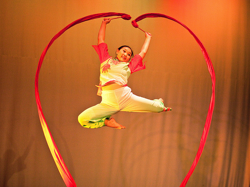

In [ ]:
compare_beam_random(idx = 10, train=True)

 --------- BEAM SEARCH (b = 5) --------- 
two guys playing soccer . <end>
two soccer players during a game . <end>
two soccer players on a grassy field . <end>
two soccer players during a football game . <end>
two soccer players during a soccer game . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> two soccer players of the opposing team getting into a fight during their game . <end>
Prediction Caption: two young men playing soccer on . <end>



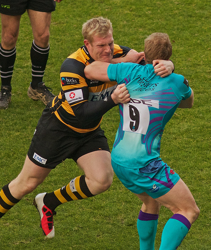

In [ ]:
compare_beam_random(idx = 20, train=True)

 --------- BEAM SEARCH (b = 5) --------- 
a dump truck crossing the street . <end>
a dump truck is parked next to a red truck . <end>
a dump truck is standing next to a green truck . <end>
a dump truck is parked next to a green truck . <end>
a dump truck is parked next to some sort of a country . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> two men standing in front of an industrial truck . <end>
Prediction Caption: a truck is giving a green truck in front of a van . <end>



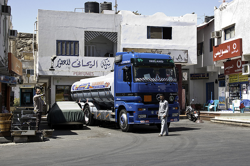

In [ ]:
compare_beam_random(idx = 100, train=True)

Now let's test beam search generator on validation set:

 --------- BEAM SEARCH (b = 5) --------- 
a woman in a short-sleeve shirt is sitting on a table . <end>
an indian man in a short-sleeve shirt is sitting on a table . <end>
an indian man in a short-sleeve shirt is sitting on his head . <end>
an indian man in a short-sleeve shirt is sitting down a city scene . <end>
an indian man in a short-sleeve shirt is sitting on a city scene . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> a woman sitting at a sewing machine looks up . <end>
Prediction Caption: an indian man with long hair is sitting in front of the city . <end>



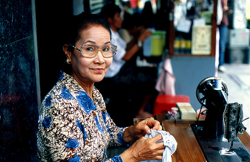

In [ ]:
compare_beam_random(idx = 85, train=False)

 --------- BEAM SEARCH (b = 5) --------- 
a man in a helmet . <end>
a motorcyclist on a motorcycle . <end>
a man in a helmet is riding a motorcycle . <end>
a man in a helmet is riding on a motorcycle . <end>
a man riding a purple and helmet is riding a motorcycle . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> a person in a specialized suit rides a motorcycle . <end>
Prediction Caption: man and motorcyclist leans under a bike with other people on a motorcycle . <end>



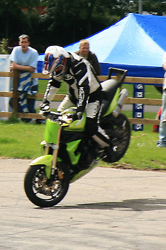

In [ ]:
compare_beam_random(idx = 200, train=False)

 --------- BEAM SEARCH (b = 5) --------- 
a dog catching a toy . <end>
a dog leaps over toy . <end>
a dog is jumping frisbee . <end>
a dog catching a frisbee . <end>
a dog is catching a toy . <end>
a dog is jumping over mouth . <end>
a dog is jumping over toy . <end>
a dog is catching a frisbee . <end>
a dog is jumping over green toy . <end>
a dog is jumping over a park . <end>
a dog is catching a frisbee involving gloves . <end>
a dog is catching a frisbee involving frisbee . <end>

 --------- RANDOM CATEGORICAL --------- 
Real Caption: <start> a tattooed man with a white dog jumping up for a stick . <end>
Prediction Caption: a dog wearing a competition catching a competition , fetching a frisbee . <end>



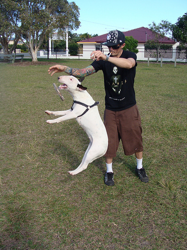

In [ ]:
compare_beam_random(idx = 400, train=False, K_beams=12)

The most obvious conclusion is that the ***beam search sentence generator*** is in favor of shorter captions. Our experiments on both sets reveal that our model is able to output better captions when using the beam search generator, however they are almost always quite shorter than the real ones. There seems to exist some trade-off between the grammatical/syntactical correctness and the length of the output captions. Given the size of our dataset, we can safely say that beam search generates better captions than our previous generator (random categorical), since its sentences are almost always correct, despite being short. Given the simplicity of our model, we would prefer to have shorter but correct sentences instead of long and frequently (grammatically) mispelled ones.

We will now evaluate the generator's output on the BLEU score, too.

### ***Model Evaluation on BLEU metric using Beam Search Generator***

We arbitrarily choose to keep the output caption with the highest accumulated probability, namely the first output.

In [ ]:
def evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=2):
    dict_of_references = get_reference_dict()

    list_of_references = []
    hypotheses = []

    c = 0
    set_of_imgs = set()
    for idx, name in notebook.tqdm(enumerate(img_name_val)):
        if name in set_of_imgs:
            continue
        set_of_imgs.add(name)

        result = beam_search_pred(encoder, decoder, optimizer, name, K_beams)
        we_keep = untokenize(result)[0]

        # process hypothesis
        if '<end>' in we_keep:
            we_keep = we_keep.split('<end>')[:-1][0]
        if we_keep[-2] == '.':
            we_keep = we_keep.split('.')[:-1][0]
        we_keep = we_keep.split(' ')[:-1]

        # process references
        reference_group = dict_of_references[img_name_val[idx]]
        processed_ref_group = []
        for i in reference_group:
            processed_ref_group.append(process_target(i))

        list_of_references.append(processed_ref_group)
        hypotheses.append(we_keep)

    bleu_metric = corpus_bleu(list_of_references, hypotheses, weights, smoothing_function)
    return bleu_metric

In [ ]:
bleu_metric = evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=5)

0it [00:00, ?it/s]

In [ ]:
print(f'Basic Model BLEU metric (Validation Set) using Beam Search Generator: {bleu_metric}')

Basic Model BLEU metric (Validation Set) using Beam Search Generator: 0.1550845977870565


We see that the model's performance is better than when we used the random categorical sentence generator. 

## ***6) Use of pretrained GloVe-wiki embeddings***

We will now use pretrained glove-wiki embeddings, hoping that we can benefit from the fact that they have resulted from training on very large datasets and the fact that we can save training time, since this layer will no longer require training.

In [ ]:
import gensim.downloader as api

for i in list(api.info()['models'].keys()):
    print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


We choose to use the 'glove-wiki-gigaword-300' embeddings.

In [ ]:
embed_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCABULARY_SIZE, EMBEDDING_DIM))

for idx, word in enumerate(tokenizer.get_vocabulary()):
    try:
        embedding_vector = embed_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[idx] = vec

In [ ]:
embedding_matrix.shape

(5000, 300)

Our embedding_matrix provides us with a 1-1 correspondence between a word and its embedding. For the words not included (must be only a few) we map them to zero vector.

In [ ]:
# define our pretrained embedding layer
pretrained_embedding_layer = tf.keras.layers.Embedding(VOCABULARY_SIZE,
                                                       EMBEDDING_DIM,
                                                       weights=[embedding_matrix],
                                                       trainable=False)

In [ ]:
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=units,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
# create a checkpoint
checkpoint_path_embed = MAIN_PATH + "checkpoints/embeddings_model"
ckpt_embed = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager_embed = tf.train.CheckpointManager(ckpt_embed, checkpoint_path_embed, max_to_keep=4)

In [ ]:
train_losses_embed, _ = train_model_re(encoder=encoder,
                                       decoder=decoder,
                                       optimizer=optimizer,
                                       train_set=dataset,
                                       val_set=[],
                                       epochs=EPOCHS,
                                       ckpt_manager=ckpt_manager_embed,
                                       early_stopping=False)

In [ ]:
bleu_metric = evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=5)

0it [00:00, ?it/s]

In [ ]:
print(f'BLEU metric for model with pretrained embeddings (Beam Search): {bleu_metric}')

BLEU metric for model with pretrained embeddings (Beam Search): 0.1609643254609674


We can observe a slight imrovement to the model's performance and a significant reduction to the training time

## ***7) Experimenting with RNN cell cardinality***

### Changing the number of cell units

First, we would like to observe whether using more or less units will actually influence performace.

#### 1024 units model

In [ ]:
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=1024,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
# create a checkpoint
checkpoint_path_1024 = MAIN_PATH + "checkpoints/model_1024"
ckpt_1024 = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager_1024 = tf.train.CheckpointManager(ckpt_1024, checkpoint_path_1024, max_to_keep=4)

In [ ]:
train_losses_1024, _ = train_model_re(encoder=encoder,
                                      decoder=decoder,
                                      optimizer=optimizer,
                                      train_set=dataset,
                                      val_set=[],
                                      epochs=EPOCHS,
                                      ckpt_manager=ckpt_manager_1024,
                                      early_stopping=False)

 --- Epoch 1 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 3.9175
Batch 100:	 Average Batch Loss 1.9507
Batch 200:	 Average Batch Loss 1.6832
Batch 300:	 Average Batch Loss 1.7931
Epoch Train Loss: 1.869604
Time taken for 1 epoch 232.22 sec

 --- Epoch 2 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.6435
Batch 100:	 Average Batch Loss 1.5798
Batch 200:	 Average Batch Loss 1.6888
Batch 300:	 Average Batch Loss 1.6003
Epoch Train Loss: 1.538212
Time taken for 1 epoch 101.72 sec

 --- Epoch 3 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.4576
Batch 100:	 Average Batch Loss 1.4765
Batch 200:	 Average Batch Loss 1.4296
Batch 300:	 Average Batch Loss 1.4324
Epoch Train Loss: 1.402613
Time taken for 1 epoch 101.10 sec

 --- Epoch 4 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.4609
Batch 100:	 Average Batch Loss 1.4352
Batch 200:	 Average Batch Loss 1.4331
Batch 300:	 Average Batch Loss 1.2114
Epoch Train Loss: 1.299413
Time taken for 1 epoch 100.58 sec

 --- Epoch 5 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.3657
Batch 100:	 Average Batch Loss 1.2213
Batch 200:	 Average Batch Loss 1.2756
Batch 300:	 Average Batch Loss 1.4226
Epoch Train Loss: 1.211725
Time taken for 1 epoch 100.50 sec

 --- Epoch 6 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.0959
Batch 100:	 Average Batch Loss 1.1074
Batch 200:	 Average Batch Loss 1.0931
Batch 300:	 Average Batch Loss 1.0715
Epoch Train Loss: 1.131391
Time taken for 1 epoch 100.46 sec

 --- Epoch 7 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.1687
Batch 100:	 Average Batch Loss 1.1077
Batch 200:	 Average Batch Loss 1.0155
Batch 300:	 Average Batch Loss 1.0272
Epoch Train Loss: 1.052669
Time taken for 1 epoch 100.36 sec

 --- Epoch 8 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.0277
Batch 100:	 Average Batch Loss 1.1099
Batch 200:	 Average Batch Loss 0.9029
Batch 300:	 Average Batch Loss 1.0650
Epoch Train Loss: 0.980148
Time taken for 1 epoch 100.73 sec

 --- Epoch 9 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9811
Batch 100:	 Average Batch Loss 1.0163
Batch 200:	 Average Batch Loss 0.8036
Batch 300:	 Average Batch Loss 0.9425
Epoch Train Loss: 0.908865
Time taken for 1 epoch 100.63 sec

 --- Epoch 10 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9464
Batch 100:	 Average Batch Loss 0.8172
Batch 200:	 Average Batch Loss 0.8072
Batch 300:	 Average Batch Loss 0.7940
Epoch Train Loss: 0.839885
Time taken for 1 epoch 100.66 sec

 --- Epoch 11 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9119
Batch 100:	 Average Batch Loss 0.7526
Batch 200:	 Average Batch Loss 0.7884
Batch 300:	 Average Batch Loss 0.7440
Epoch Train Loss: 0.777316
Time taken for 1 epoch 100.58 sec

 --- Epoch 12 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7654
Batch 100:	 Average Batch Loss 0.6955
Batch 200:	 Average Batch Loss 0.6875
Batch 300:	 Average Batch Loss 0.6591
Epoch Train Loss: 0.715947
Time taken for 1 epoch 100.77 sec

 --- Epoch 13 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7454
Batch 100:	 Average Batch Loss 0.6778
Batch 200:	 Average Batch Loss 0.6578
Batch 300:	 Average Batch Loss 0.6098
Epoch Train Loss: 0.664501
Time taken for 1 epoch 100.61 sec

 --- Epoch 14 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6855
Batch 100:	 Average Batch Loss 0.6160
Batch 200:	 Average Batch Loss 0.5871
Batch 300:	 Average Batch Loss 0.5087
Epoch Train Loss: 0.615952
Time taken for 1 epoch 100.77 sec

 --- Epoch 15 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6612
Batch 100:	 Average Batch Loss 0.5898
Batch 200:	 Average Batch Loss 0.5487
Batch 300:	 Average Batch Loss 0.5080
Epoch Train Loss: 0.572498
Time taken for 1 epoch 100.86 sec

 --- Epoch 16 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5853
Batch 100:	 Average Batch Loss 0.5498
Batch 200:	 Average Batch Loss 0.5396
Batch 300:	 Average Batch Loss 0.5098
Epoch Train Loss: 0.532534
Time taken for 1 epoch 100.49 sec

 --- Epoch 17 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5257
Batch 100:	 Average Batch Loss 0.5164
Batch 200:	 Average Batch Loss 0.5308
Batch 300:	 Average Batch Loss 0.5102
Epoch Train Loss: 0.499266
Time taken for 1 epoch 100.79 sec

 --- Epoch 18 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5179
Batch 100:	 Average Batch Loss 0.4656
Batch 200:	 Average Batch Loss 0.4591
Batch 300:	 Average Batch Loss 0.4377
Epoch Train Loss: 0.468947
Time taken for 1 epoch 101.37 sec

 --- Epoch 19 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.4186
Batch 100:	 Average Batch Loss 0.5005
Batch 200:	 Average Batch Loss 0.4014
Batch 300:	 Average Batch Loss 0.4756
Epoch Train Loss: 0.441801
Time taken for 1 epoch 100.53 sec

 --- Epoch 20 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.4707
Batch 100:	 Average Batch Loss 0.4312
Batch 200:	 Average Batch Loss 0.4265
Batch 300:	 Average Batch Loss 0.3955
Epoch Train Loss: 0.419774
Time taken for 1 epoch 102.52 sec



We observe that the train loss is constantly lower than the one the 512 units model had during the respective epochs. The final loss is much lower than any we achieved before. It seems that a model with more units can perform better. There is also a possibility that the model can reduce the training error even further by training for more epochs.

Let's see now the BLEU metric.

In [ ]:
bleu_metric = evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=5)

0it [00:00, ?it/s]

In [ ]:
print(f'BLEU metric for model with 1024 units (GloVe-wiki-300 + Beam Search): {bleu_metric}')

BLEU metric for model with 1024 units (GloVe-wiki-300 + Beam Search): 0.1665106969910531


Again, a slight improvement to the BLEU metric. It seems that the training loss does not necessarily reflect a significant improvement of the BLEU.

#### 256 units model

In [ ]:
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=256,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
# create a checkpoint
checkpoint_path_256 = MAIN_PATH + "checkpoints/model_256"
ckpt_256 = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager_256 = tf.train.CheckpointManager(ckpt_256, checkpoint_path_256, max_to_keep=4)

In [ ]:
train_losses_256, _ = train_model_re(encoder=encoder,
                                     decoder=decoder,
                                     optimizer=optimizer,
                                     train_set=dataset,
                                     val_set=[],
                                     epochs=EPOCHS,
                                     ckpt_manager=ckpt_manager_256,
                                     early_stopping=False)

 --- Epoch 1 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 4.0592
Batch 100:	 Average Batch Loss 2.3694
Batch 200:	 Average Batch Loss 1.9218
Batch 300:	 Average Batch Loss 1.7861
Epoch Train Loss: 2.102416
Time taken for 1 epoch 176.97 sec

 --- Epoch 2 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.7876
Batch 100:	 Average Batch Loss 1.7851
Batch 200:	 Average Batch Loss 1.7504
Batch 300:	 Average Batch Loss 1.4568
Epoch Train Loss: 1.643150
Time taken for 1 epoch 81.96 sec

 --- Epoch 3 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.5126
Batch 100:	 Average Batch Loss 1.3766
Batch 200:	 Average Batch Loss 1.5271
Batch 300:	 Average Batch Loss 1.4801
Epoch Train Loss: 1.494656
Time taken for 1 epoch 80.35 sec

 --- Epoch 4 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.4496
Batch 100:	 Average Batch Loss 1.4366
Batch 200:	 Average Batch Loss 1.3243
Batch 300:	 Average Batch Loss 1.2699
Epoch Train Loss: 1.387911
Time taken for 1 epoch 81.39 sec

 --- Epoch 5 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.4870
Batch 100:	 Average Batch Loss 1.2397
Batch 200:	 Average Batch Loss 1.3392
Batch 300:	 Average Batch Loss 1.2858
Epoch Train Loss: 1.300323
Time taken for 1 epoch 80.54 sec

 --- Epoch 6 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.3194
Batch 100:	 Average Batch Loss 1.2125
Batch 200:	 Average Batch Loss 1.2385
Batch 300:	 Average Batch Loss 1.0832
Epoch Train Loss: 1.224570
Time taken for 1 epoch 81.45 sec

 --- Epoch 7 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.2534
Batch 100:	 Average Batch Loss 1.2363
Batch 200:	 Average Batch Loss 1.2857
Batch 300:	 Average Batch Loss 1.0914
Epoch Train Loss: 1.157338
Time taken for 1 epoch 81.33 sec

 --- Epoch 8 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.0990
Batch 100:	 Average Batch Loss 1.0900
Batch 200:	 Average Batch Loss 1.0753
Batch 300:	 Average Batch Loss 1.1037
Epoch Train Loss: 1.095117
Time taken for 1 epoch 81.06 sec

 --- Epoch 9 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.1049
Batch 100:	 Average Batch Loss 1.0881
Batch 200:	 Average Batch Loss 1.1666
Batch 300:	 Average Batch Loss 1.0117
Epoch Train Loss: 1.038312
Time taken for 1 epoch 80.92 sec

 --- Epoch 10 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.0759
Batch 100:	 Average Batch Loss 1.0028
Batch 200:	 Average Batch Loss 1.0535
Batch 300:	 Average Batch Loss 0.9324
Epoch Train Loss: 0.989315
Time taken for 1 epoch 80.82 sec

 --- Epoch 11 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9603
Batch 100:	 Average Batch Loss 1.0110
Batch 200:	 Average Batch Loss 0.9768
Batch 300:	 Average Batch Loss 0.8749
Epoch Train Loss: 0.940448
Time taken for 1 epoch 81.14 sec

 --- Epoch 12 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9901
Batch 100:	 Average Batch Loss 0.8031
Batch 200:	 Average Batch Loss 0.8385
Batch 300:	 Average Batch Loss 0.8539
Epoch Train Loss: 0.896283
Time taken for 1 epoch 81.16 sec

 --- Epoch 13 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9157
Batch 100:	 Average Batch Loss 0.7693
Batch 200:	 Average Batch Loss 0.8794
Batch 300:	 Average Batch Loss 0.8188
Epoch Train Loss: 0.853892
Time taken for 1 epoch 81.76 sec

 --- Epoch 14 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.8398
Batch 100:	 Average Batch Loss 0.8409
Batch 200:	 Average Batch Loss 0.7797
Batch 300:	 Average Batch Loss 0.8439
Epoch Train Loss: 0.814910
Time taken for 1 epoch 80.91 sec

 --- Epoch 15 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.8589
Batch 100:	 Average Batch Loss 0.8155
Batch 200:	 Average Batch Loss 0.8154
Batch 300:	 Average Batch Loss 0.8291
Epoch Train Loss: 0.780290
Time taken for 1 epoch 86.36 sec

 --- Epoch 16 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.8071
Batch 100:	 Average Batch Loss 0.7123
Batch 200:	 Average Batch Loss 0.7291
Batch 300:	 Average Batch Loss 0.6873
Epoch Train Loss: 0.746155
Time taken for 1 epoch 82.92 sec

 --- Epoch 17 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7543
Batch 100:	 Average Batch Loss 0.7039
Batch 200:	 Average Batch Loss 0.7760
Batch 300:	 Average Batch Loss 0.7395
Epoch Train Loss: 0.714751
Time taken for 1 epoch 85.66 sec

 --- Epoch 18 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7160
Batch 100:	 Average Batch Loss 0.7286
Batch 200:	 Average Batch Loss 0.7226
Batch 300:	 Average Batch Loss 0.7072
Epoch Train Loss: 0.687358
Time taken for 1 epoch 82.26 sec

 --- Epoch 19 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7410
Batch 100:	 Average Batch Loss 0.5924
Batch 200:	 Average Batch Loss 0.6588
Batch 300:	 Average Batch Loss 0.6957
Epoch Train Loss: 0.665321
Time taken for 1 epoch 81.45 sec

 --- Epoch 20 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6923
Batch 100:	 Average Batch Loss 0.6606
Batch 200:	 Average Batch Loss 0.6226
Batch 300:	 Average Batch Loss 0.6619
Epoch Train Loss: 0.633635
Time taken for 1 epoch 96.73 sec



We see that the 256-units model is more difficult to train. The train loss is higher than our previous models and, given the size of our dataset, it seems that it will generally underperform on a larger dataset.

Let's see the BLEU.

In [ ]:
bleu_metric = evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=5)

0it [00:00, ?it/s]

In [ ]:
print(f'BLEU metric for model with 265 units (GloVe-wiki-300 + Beam Search): {bleu_metric}')

BLEU metric for model with 265 units (GloVe-wiki-300 + Beam Search): 0.1552152166309727


Despite the models higher training loss, we see that the captions it produces are of similar quality to the previous models' according to the BLEU metric.

It is very probable that the models' performances are similar due to the fact that we generate captions with Beam Search, which we have observed that favors shorter captions. When experimenting on our final models (later on) we will test it using both Beam Search and Random Categorical.

## ***Adding Dropout near the Dense Layers of the Decoder***

Apart from adding dropout, we will incorporate our best choices so far and train the model for 20 epochs. After evaluating on the validation set (BLEU) we will train it for 5 more epochs to observe the result.

In [ ]:
class RNN_Decoder_Dropout(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, drop_prob=0.2):
        super(RNN_Decoder_Dropout, self).__init__()
        self.units = units
        self.drop_prob = drop_prob
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        # dropout
        self.dropout1 = tf.keras.layers.Dropout(self.drop_prob)
        self.dropout2 = tf.keras.layers.Dropout(self.drop_prob)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        # Dropout 1
        x = self.dropout1(output)
        x = self.fc1(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        # Dropout 2
        x = self.dropout2(x)
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# initialize a new model
encoder, _, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                         units=1024,
                                         tokenizer=tokenizer,
                                         learning_rate=lr)
decoder = RNN_Decoder_Dropout(embedding_dim=EMBEDDING_DIM,
                              units=1024,
                              vocab_size=tokenizer.vocabulary_size(),
                              drop_prob=0.2)
decoder.embedding = pretrained_embedding_layer

In [ ]:
# create a checkpoint
checkpoint_path_Dropout = MAIN_PATH + "checkpoints/model_Dropout"
ckpt_Dropout = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager_Dropout = tf.train.CheckpointManager(ckpt_Dropout, checkpoint_path_Dropout, max_to_keep=4)

In [ ]:
train_losses_Dropout, _ = train_model_re(encoder=encoder,
                                         decoder=decoder,
                                         optimizer=optimizer,
                                         train_set=dataset,
                                         val_set=[],
                                         epochs=25,
                                         ckpt_manager=ckpt_manager_Dropout,
                                         early_stopping=False)

 --- Epoch 1 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 3.9603
Batch 100:	 Average Batch Loss 1.9330
Batch 200:	 Average Batch Loss 1.7881
Batch 300:	 Average Batch Loss 1.7240
Epoch Train Loss: 1.841721
Time taken for 1 epoch 292.69 sec

 --- Epoch 2 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.8586
Batch 100:	 Average Batch Loss 1.5822
Batch 200:	 Average Batch Loss 1.4830
Batch 300:	 Average Batch Loss 1.4957
Epoch Train Loss: 1.520530
Time taken for 1 epoch 216.27 sec

 --- Epoch 3 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.5033
Batch 100:	 Average Batch Loss 1.2804
Batch 200:	 Average Batch Loss 1.4838
Batch 300:	 Average Batch Loss 1.4329
Epoch Train Loss: 1.382894
Time taken for 1 epoch 216.32 sec

 --- Epoch 4 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.4805
Batch 100:	 Average Batch Loss 1.2645
Batch 200:	 Average Batch Loss 1.3427
Batch 300:	 Average Batch Loss 1.2173
Epoch Train Loss: 1.278689
Time taken for 1 epoch 216.33 sec

 --- Epoch 5 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.2698
Batch 100:	 Average Batch Loss 1.2304
Batch 200:	 Average Batch Loss 1.1323
Batch 300:	 Average Batch Loss 1.2603
Epoch Train Loss: 1.185133
Time taken for 1 epoch 216.18 sec

 --- Epoch 6 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.1899
Batch 100:	 Average Batch Loss 1.1073
Batch 200:	 Average Batch Loss 1.0879
Batch 300:	 Average Batch Loss 1.0369
Epoch Train Loss: 1.101296
Time taken for 1 epoch 216.27 sec

 --- Epoch 7 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.1182
Batch 100:	 Average Batch Loss 1.0703
Batch 200:	 Average Batch Loss 0.9736
Batch 300:	 Average Batch Loss 0.8765
Epoch Train Loss: 1.021579
Time taken for 1 epoch 216.45 sec

 --- Epoch 8 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.9726
Batch 100:	 Average Batch Loss 0.9253
Batch 200:	 Average Batch Loss 1.1457
Batch 300:	 Average Batch Loss 0.9647
Epoch Train Loss: 0.943713
Time taken for 1 epoch 217.19 sec

 --- Epoch 9 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 1.0078
Batch 100:	 Average Batch Loss 0.9547
Batch 200:	 Average Batch Loss 0.9009
Batch 300:	 Average Batch Loss 0.8887
Epoch Train Loss: 0.870362
Time taken for 1 epoch 217.11 sec

 --- Epoch 10 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.7764
Batch 100:	 Average Batch Loss 0.7784
Batch 200:	 Average Batch Loss 0.8136
Batch 300:	 Average Batch Loss 0.7614
Epoch Train Loss: 0.803652
Time taken for 1 epoch 216.47 sec

 --- Epoch 11 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.8406
Batch 100:	 Average Batch Loss 0.5975
Batch 200:	 Average Batch Loss 0.7018
Batch 300:	 Average Batch Loss 0.7138
Epoch Train Loss: 0.740137
Time taken for 1 epoch 216.76 sec

 --- Epoch 12 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6893
Batch 100:	 Average Batch Loss 0.6539
Batch 200:	 Average Batch Loss 0.6307
Batch 300:	 Average Batch Loss 0.7185
Epoch Train Loss: 0.682518
Time taken for 1 epoch 216.74 sec

 --- Epoch 13 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6636
Batch 100:	 Average Batch Loss 0.5925
Batch 200:	 Average Batch Loss 0.6531
Batch 300:	 Average Batch Loss 0.5981
Epoch Train Loss: 0.630053
Time taken for 1 epoch 217.02 sec

 --- Epoch 14 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.6536
Batch 100:	 Average Batch Loss 0.6643
Batch 200:	 Average Batch Loss 0.6332
Batch 300:	 Average Batch Loss 0.6153
Epoch Train Loss: 0.582572
Time taken for 1 epoch 216.58 sec

 --- Epoch 15 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5203
Batch 100:	 Average Batch Loss 0.4570
Batch 200:	 Average Batch Loss 0.4805
Batch 300:	 Average Batch Loss 0.5292
Epoch Train Loss: 0.543477
Time taken for 1 epoch 216.26 sec

 --- Epoch 16 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5542
Batch 100:	 Average Batch Loss 0.4864
Batch 200:	 Average Batch Loss 0.5015
Batch 300:	 Average Batch Loss 0.5016
Epoch Train Loss: 0.505003
Time taken for 1 epoch 216.53 sec

 --- Epoch 17 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.5195
Batch 100:	 Average Batch Loss 0.4373
Batch 200:	 Average Batch Loss 0.5205
Batch 300:	 Average Batch Loss 0.4329
Epoch Train Loss: 0.474124
Time taken for 1 epoch 216.99 sec

 --- Epoch 18 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.4781
Batch 100:	 Average Batch Loss 0.4473
Batch 200:	 Average Batch Loss 0.4496
Batch 300:	 Average Batch Loss 0.4027
Epoch Train Loss: 0.446609
Time taken for 1 epoch 216.64 sec

 --- Epoch 19 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.4772
Batch 100:	 Average Batch Loss 0.4067
Batch 200:	 Average Batch Loss 0.4054
Batch 300:	 Average Batch Loss 0.4217
Epoch Train Loss: 0.424783
Time taken for 1 epoch 216.77 sec

 --- Epoch 20 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.4068
Batch 100:	 Average Batch Loss 0.4251
Batch 200:	 Average Batch Loss 0.3940
Batch 300:	 Average Batch Loss 0.3900
Epoch Train Loss: 0.400891
Time taken for 1 epoch 216.55 sec

 --- Epoch 21 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.3878
Batch 100:	 Average Batch Loss 0.3403
Batch 200:	 Average Batch Loss 0.3441
Batch 300:	 Average Batch Loss 0.4031
Epoch Train Loss: 0.383624
Time taken for 1 epoch 216.72 sec

 --- Epoch 22 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.3688
Batch 100:	 Average Batch Loss 0.3911
Batch 200:	 Average Batch Loss 0.4196
Batch 300:	 Average Batch Loss 0.3512
Epoch Train Loss: 0.370011
Time taken for 1 epoch 216.07 sec

 --- Epoch 23 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.3649
Batch 100:	 Average Batch Loss 0.3782
Batch 200:	 Average Batch Loss 0.4037
Batch 300:	 Average Batch Loss 0.3585
Epoch Train Loss: 0.353571
Time taken for 1 epoch 216.76 sec

 --- Epoch 24 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.3623
Batch 100:	 Average Batch Loss 0.3420
Batch 200:	 Average Batch Loss 0.3659
Batch 300:	 Average Batch Loss 0.3092
Epoch Train Loss: 0.339938
Time taken for 1 epoch 216.35 sec

 --- Epoch 25 --- 


0it [00:00, ?it/s]

Batch 0:	 Average Batch Loss 0.3292
Batch 100:	 Average Batch Loss 0.3449
Batch 200:	 Average Batch Loss 0.3458
Batch 300:	 Average Batch Loss 0.3047
Epoch Train Loss: 0.335178
Time taken for 1 epoch 216.41 sec



In [ ]:
bleu_metric = evaluate_model_BLEU_BEAM(encoder, decoder, optimizer, img_name_val, K_beams=5)

0it [00:00, ?it/s]

In [ ]:
print(f'BLEU metric for model with dropout (1024 units + GloVe-wiki-300 + Beam Search): {bleu_metric}')

BLEU metric for model with dropout (1024 units + GloVe-wiki-300 + Beam Search): 0.1652152166309727


We see that the addition of dropout does not affect the performance of the model given the other parameters and hyperparameters.

## ***Final Model***

Due to Colab's extreme delay in loading the dataset from Drive it was not feasible for us to conduct larger experiments. The solution we resorted to was to move our code to Kaggle and train the rest of our models there. We conducted several experiments, all of which are included in the list below.

## ***Competition Entry***

We also entered the competition and kept the BLEU scores that our models achieved. The code for using our model to produce captions and create a valid txt file is given below.

In [ ]:
# initialize a new model
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                         units=1024,
                                         tokenizer=tokenizer,
                                         learning_rate=lr)

decoder.embedding = pretrained_embedding_layer

In [ ]:
encoder, decoder, optimizer = restore_saved_model('/content/drive/MyDrive/nn_lab3/checkpoints/model_final', encoder, decoder, optimizer)

Restored from /content/drive/MyDrive/nn_lab3/checkpoints/model_final/ckpt-4


In [ ]:
with open(test_images_file, 'r') as f:
    test_images = pd.read_csv(f, sep='|', header=None, quoting=3)
test_images.columns = ["Image"]

We generated captions using two ways. The first one was to use beam search generator and use the caption with the highest probability. The second one was to produce `K_beams` captions and choose between them using random.categorical based on their probabilities.

### ***1) Beam Search + Random.Categorical***

In [ ]:
test_image_list = []
for index, val in test_images.iterrows():
    image_path = MAIN_PATH + 'image_dir/' + val['Image']
    test_image_list.append(image_path)

In [ ]:
competition_captions = []
for idx, img in enumerate(test_image_list):
    captions_probs = beam_search_pred(encoder, decoder, optimizer, img, K_beams=5)
    captions = untokenize(captions_probs)
    
    probs = []
    for i in captions_probs:
        probs.append(i[1])

    chosen_caption_idx = tf.random.categorical([probs], 1).numpy()[0][0]
    chosen_caption = captions[chosen_caption_idx]
    chosen_caption = chosen_caption.split(' ')

    if chosen_caption[-1] == '<end>':
        chosen_caption = chosen_caption[:-1]
    if chosen_caption[-1] == '.':
        chosen_caption = chosen_caption[:-1]
    competition_captions.append(chosen_caption)

In [ ]:
jsonString = json.dumps(competition_captions)
jsonFile = open("test_hypotheses_beam.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

### ***2) Beam Search (Most probable Caption)***

In [ ]:
competition_captions_beam_first = []
for idx, img in enumerate(test_image_list):
    
    captions_probs = beam_search_pred(encoder, decoder, optimizer, img, K_beams=5)
    captions = untokenize(captions_probs)
    
    probs = []
    for i in captions_probs:
        probs.append(i[1])

    chosen_caption_idx = 0
    chosen_caption = captions[chosen_caption_idx]
    chosen_caption = chosen_caption.split(' ')

    if chosen_caption[-1] == '<end>':
        chosen_caption = chosen_caption[:-1]
    if chosen_caption[-1] == '.':
        chosen_caption = chosen_caption[:-1]
    competition_captions_beam_first.append(chosen_caption)

In [ ]:
jsonString = json.dumps(competition_captions_beam_first)
jsonFile = open("test_hypotheses_beam_first.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

Based on the BLEU evaluation of the competition, both ways of producing captions results in the same BLEU metric.

## ***Résumé***

\begin{array}{c} \hline
\text{Models} & \text{units} & \text{GloVe-wiki} & \text{dropout} & \text{dataset} & \text{vocab_size} & \text{BATCH_SIZE} & \text{EPOCHS} & \text{BLEU (rand/categ)} & \text{BLEU (beam search)} \\ \hline
\text{Basic} & 512 & ❌ & ❌ & 20\% & 5000 & 64 & 20 & 0.1168 & 0.1550 \\
\text{Test1} & 512 & ✅ & ❌ & 20\% & 5000 & 64 & 20 & ➖ & 0.1610 \\
\text{Test2} & 1024 & ✅ & ❌ & 20\% & 5000 & 64 & 20 & ➖ & 0.1665 \\
\text{Test3} & 256 & ✅ & ❌ & 20\% & 5000 & 64 & 20 & ➖ & 0.1552 \\
\text{Test4} & 1024 & ✅ & ✅ & 20\% & 5000 & 64 & 20 & ➖ & 0.1652 \\
\text{Comp.Entry1} & 1024 & ✅ & ✅ & 20\% & 5000 & 64 & 25 & 0.1730 & 0.2641	 \\
\text{Comp.Entry2} & 1024 & ✅ & ✅ & 50\% & 6500 & 128 & 30 & ➖ & 0.2377	 \\
\text{Comp.Entry3} & 1024 & ✅ & ✅ & 50\% & 6500 & 128 & 35 & ➖ & 0.2279	 \\
\text{Comp.Entry4} & 1024 & ✅ & ❌ & 33.3\% & 5000 & 64 & 5 & ➖ & 0.3079	 \\
\text{Comp.Entry5} & 1024 & ✅ & ❌ & 33.3\% & 5000 & 64 & 1 & ➖ & 0.2962	 \\
\text{Comp.Entry6} & 1024 & ✅ & ❌ & 56.7\% & 5000 & 64 & 2 & ➖ & 0.3357	 \\ \hline
\end{array}

After several experiments (we conducted more than the ones listed) we observed that the models had better performance when they were trained for less epochs. We arranged our code to evaluate each model on its BLEU score every 10 epochs and we realised that the BLEU was always better at 10 epochs than it was afterwards. We checked the captions produced and they were indeed better. This implies that the dataset used is large enough for our model to learn if trained for a few epochs. Not only that, training (this specific architecture) for more epochs results in some kind of overfitting, therefore reducing the performance metrics.

We confirmed our thoughts by submitting our trained-on-a-few-epochs models to the competition and achieving the highest values for these models. At the moment of writing, our best model is trained for 2 epochs on the 56.7% of the whole dataset and outperforms every other submission of the competition, ***ranking us first with a BLEU score of 0.3357***.